In [2]:
import gt4py as gt
from gt4py import gtscript
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import os
os.environ['CFLAGS'] = '-Wno-depxrecated-declarations'
os.environ['CXXFLAGS'] = '-Wno-deprecated-declarations'
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="Distutils was imported before Setuptools")

/users/class154/HPC4WC_venv/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Diffusion plot

In [2]:
def validate_results(version=""):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4),dpi=300)

    in_field = np.load(f'in_field{version}.npy')
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0],fraction=0.046, pad=0.04)
    axs[0].set_title("Initial condition")

    out_field = np.load(f'out_field{version}.npy')
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1],fraction=0.046, pad=0.04)
    axins = axs[1].inset_axes([0.6, 0.6, 0.3, 0.3], xlim=(750, 780), ylim=(750, 780))
    axins.imshow(out_field[out_field.shape[0] // 2, :, :],origin="lower", vmin=-0.1, vmax=1.1)
    axins.axes.xaxis.set_ticks_position('both')
    axins.tick_params(axis='x', direction='in', colors='darkgreen', labelsize=4)
    axins.axes.yaxis.set_ticks_position('both')
    axins.tick_params(axis='y', direction='in', colors='darkgreen', labelsize=4)

    axs[1].set_title("After diffusion")
    plt.tight_layout()
    plt.savefig(f'plots/diffusion_{version}.png')
    plt.show()

Validate first MPI integrated GT4py implementation:

In [3]:
!srun -n 1 python stencil2d-gt4py-mpi-base.py --nx 1024 --ny 1024 --nz 128 --num_iter 256 --backend gt:cpu_ifirst

Elapsed time for work = 21.988226890563965 s


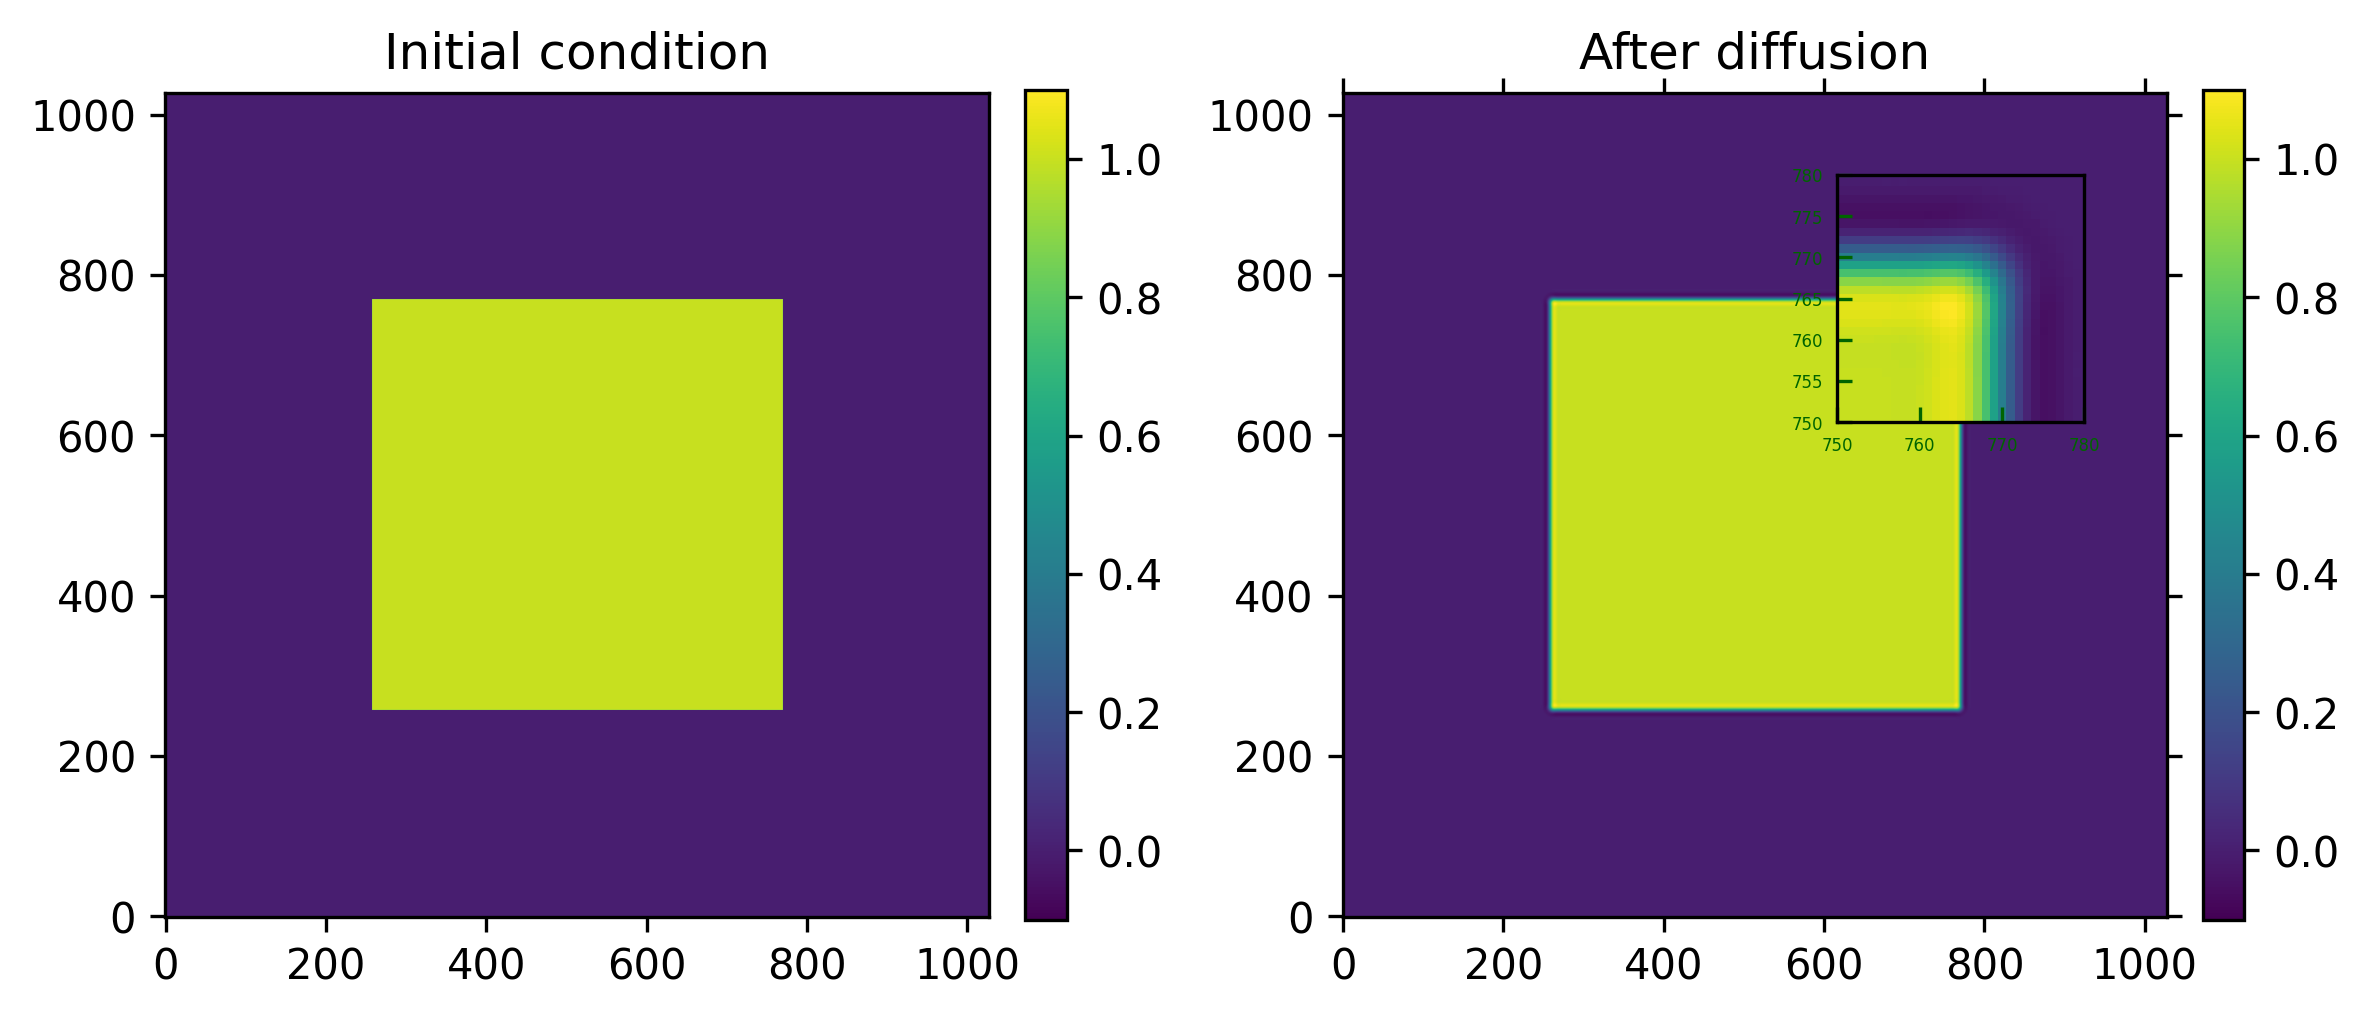

In [4]:
validate_results("-gt4py-mpi-base")

Validate MPI integrated GT4py implementation with a different laplacian

In [5]:
!srun -n 1 python stencil2d-gt4py-mpi-laplacian.py --nx 1024 --ny 1024 --nz 128 --num_iter 256 --backend gt:cpu_ifirst

Elapsed time for work = 21.895101308822632 s


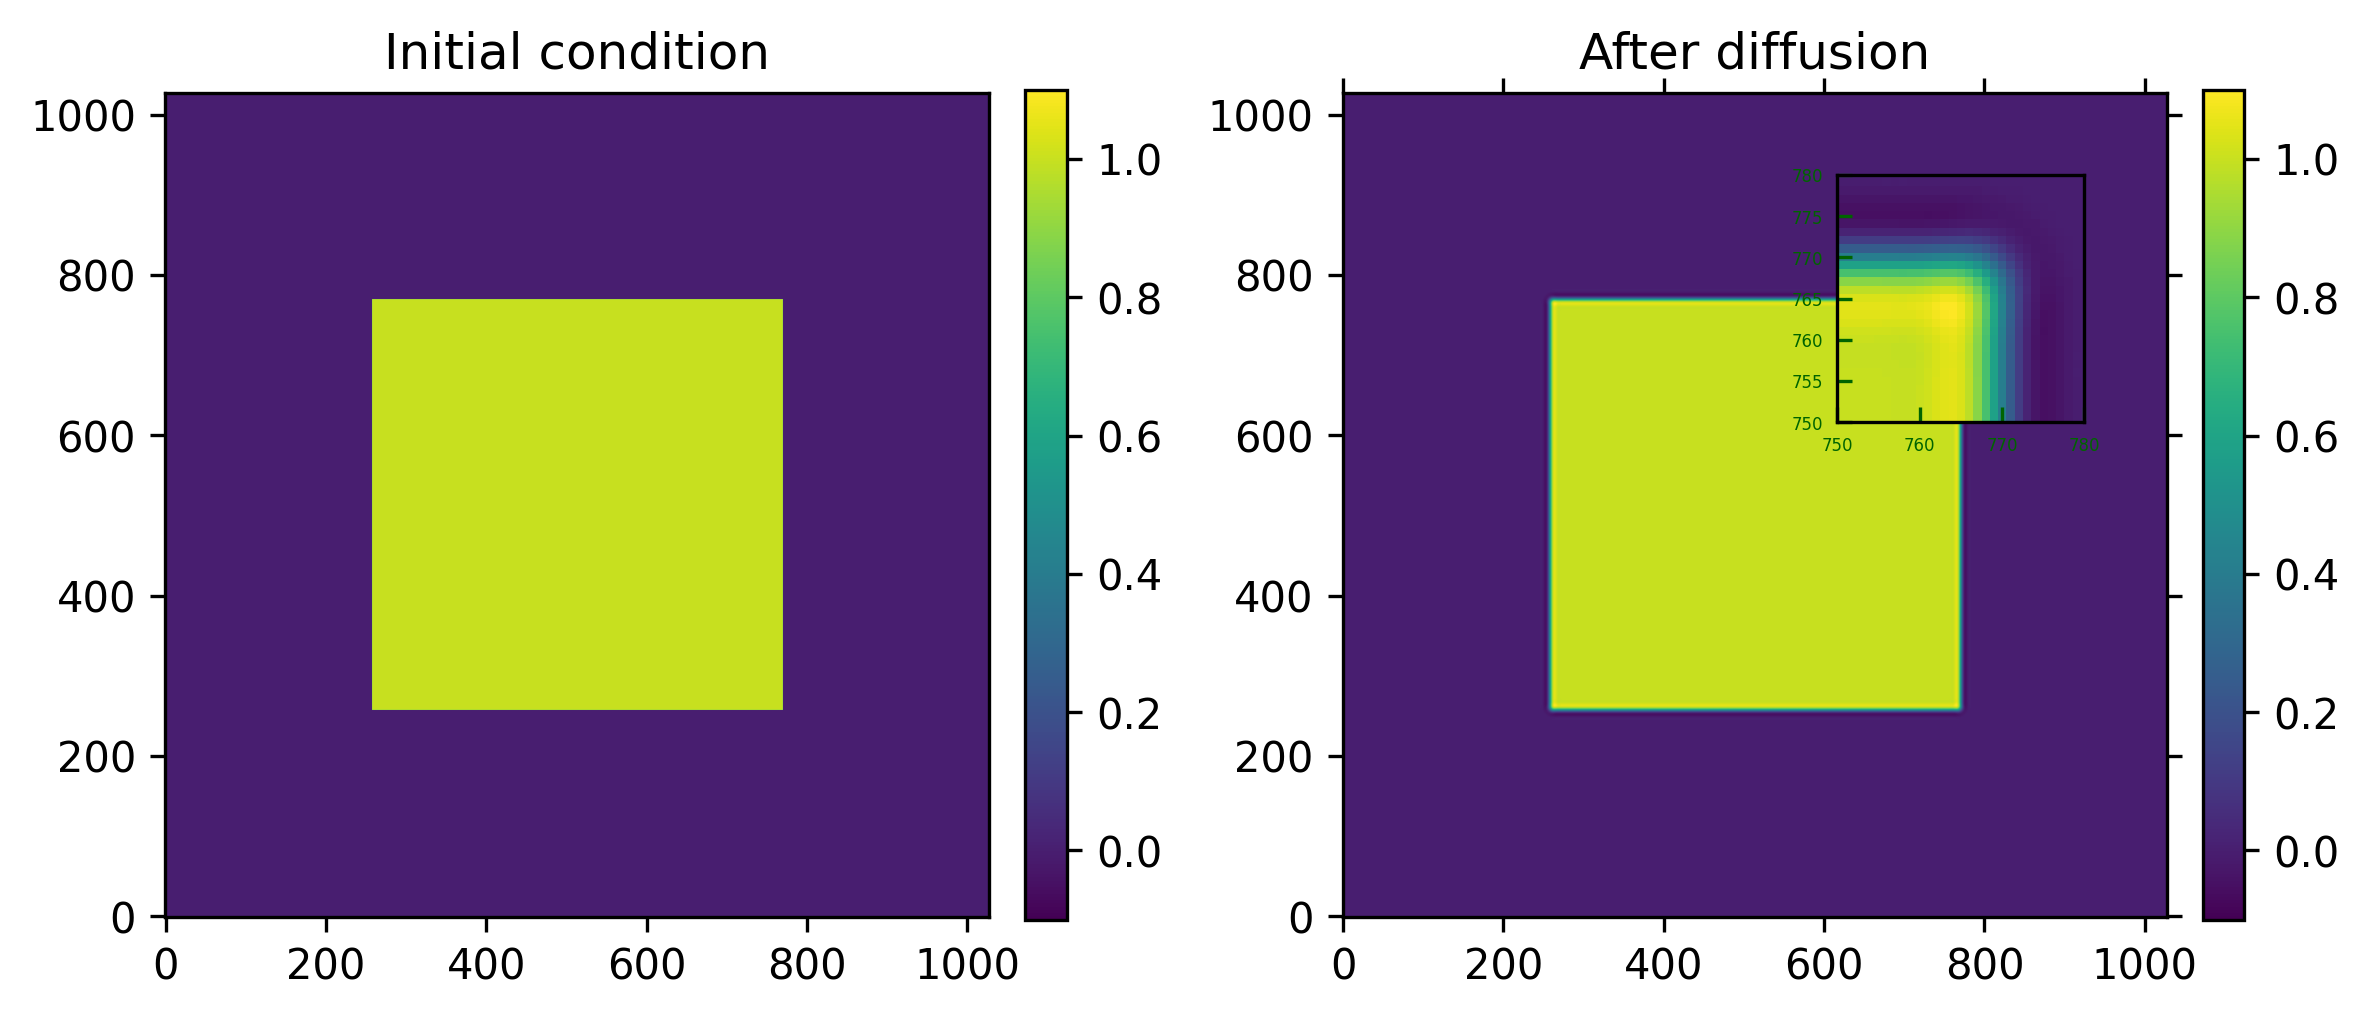

In [6]:
validate_results("-gt4py-mpi-laplacian")

### Strong scaling: Run times

Get runtimes for the first MPI integrated GT4py implementation

In [ ]:
%%bash
backends=("gt:cpu_kfirst" "gt:cpu_ifirst" "numpy")
version="base"
script_name="stencil2d-gt4py-mpi-${version}"
folder="data"
nx=1028 #64
ny=1028 #64
nz=128 #32
num_iter=256

for backend in "${backends[@]}" ; do
    output_file="elapsed_times_${version}_${backend}.txt"
    > $output_file
    for nthreads in seq 1 24 ; do
      ncores=$nthreads
      if [ $nthreads -gt 24 ] ; then
        ncores=24
      fi
      elapsed_time=$(srun -n $ncores python ${script_name}.py --nx $nx --ny $ny --nz $nz --num_iter $num_iter --backend $backend | sed -n 's/.*Elapsed time for work = \([0-9.]*\) s.*/\1/p')
      echo "$ncores, $elapsed_time" >> $output_file
    done
    mv $output_file ${folder}/$output_file
done 


Get runtimes for the modified MPI integrated GT4py implementation

In [ ]:
%%bash
backends=("gt:cpu_kfirst" "gt:cpu_ifirst" "numpy")
version="laplacian"
script_name="stencil2d-gt4py-mpi-${version}"
folder="data"
nx=1028 #64
ny=1028 #64
nz=128 #32
num_iter=256

for backend in "${backends[@]}" ; do
    output_file="elapsed_times_${version}_${backend}.txt"
    > $output_file
    for nthreads in `seq 1 24` ; do
      ncores=$nthreads
      if [ $nthreads -gt 24 ] ; then
        ncores=24
      fi
      elapsed_time=$(srun -n $ncores python ${script_name}.py --nx $nx --ny $ny --nz $nz --num_iter $num_iter --backend $backend | sed -n 's/.*Elapsed time for work = \([0-9.]*\) s.*/\1/p')
      echo "$ncores, $elapsed_time" >> $output_file
    done
    mv $output_file ${folder}/$output_file
done

Get runtimes for GT4py base implementation

In [2]:
%%bash
backends=("gt:cpu_kfirst" "gt:cpu_ifirst" "numpy")
version="GT4py_ref"
script_name="stencil2d-gt4py"
folder="data"
nx=1028 #64
ny=1028 #64
nz=128 #32
num_iter=256

for backend in "${backends[@]}" ; do
    output_file="elapsed_times_${version}_${backend}.txt"
    > $output_file
    for nthreads in `seq 22 24` ; do
      ncores=$nthreads
      if [ $nthreads -gt 24 ] ; then
        ncores=24
      fi
      elapsed_time=$(srun -n $ncores python ${script_name}.py --nx $nx --ny $ny --nz $nz --num_iter $num_iter --backend $backend | sed -n 's/.*Elapsed time for work = \([0-9.]*\) s.*/\1/p')
      echo "$ncores, $elapsed_time" >> $output_file
    done
    #mv $output_file ${folder}/$output_file
done

srun: First task exited 30s ago
srun: StepId=55802859.1 tasks 0-21: running
srun: StepId=55802859.1 task 22: exited
srun: launch/slurm: _step_signal: Terminating StepId=55802859.1
srun: Job step aborted: Waiting up to 92 seconds for job step to finish.
slurmstepd: error: *** STEP 55802859.1 ON nid03284 CANCELLED AT 2024-08-28T08:52:22 ***
srun: error: nid03284: tasks 0-21: Killed
srun: launch/slurm: _step_signal: Terminating StepId=55802859.1
srun: First task exited 30s ago
srun: StepId=55802859.2 tasks 0-4,6-23: running
srun: StepId=55802859.2 task 5: exited
srun: launch/slurm: _step_signal: Terminating StepId=55802859.2
srun: Job step aborted: Waiting up to 92 seconds for job step to finish.
slurmstepd: error: *** STEP 55802859.2 ON nid03284 CANCELLED AT 2024-08-28T09:11:53 ***
srun: error: nid03284: task 17: Killed
srun: launch/slurm: _step_signal: Terminating StepId=55802859.2
srun: error: nid03284: tasks 0-4,6-16,18-23: Killed
slurmstepd: error: Detected 1 oom-kill event(s) in Ste

Get runtimes for MPI base implementation

In [ ]:
%%bash
version="mpi_ref"
script_name="stencil2d-mpi"
folder="data"
nx=1028 #64
ny=1028 #64
nz=128 #32
num_iter=256

output_file="elapsed_times_${version}_numpy.txt"
> $output_file
for nthreads in `seq 1 24` ; do
  ncores=$nthreads
  if [ $nthreads -gt 24 ] ; then
    ncores=24
  fi
  elapsed_time=$(srun -n $ncores python ${script_name}.py --nx $nx --ny $ny --nz $nz --num_iter $num_iter | sed -n 's/.*Elapsed time for work = \([0-9.]*\) s.*/\1/p')
  echo "$ncores, $elapsed_time" >> $output_file
done
mv $output_file ${folder}/$output_file

### Plot run times

In [4]:
def read_load_runtimes(backend, version):
    labels = []
    times = []
    # Open the file and read line by line
    with open(f'data/elapsed_times_{version}_{backend}.txt', 'r') as file:
        for line in file:
            # Strip any leading/trailing whitespace and split the line by comma
            parts = line.strip().split(',')
            if len(parts) == 2:
                # Append the value and time to the respective lists
                labels.append(int(parts[0]))
                times.append(float(parts[1]))
    return times, labels

In [5]:
def create_figure_absolute(backends, versions, title, name, label):
    fig = plt.figure(figsize=(4,3),dpi=300)
    ax = fig.add_axes([0, 0, 1, 1])
    width = 0.9/(len(backends)*len(versions))
    x=np.arange(1,25)
    i=0
    for j,version in enumerate(versions):
        for backend in backends:
            times, labels = read_load_runtimes(backend, version)
            ax.bar(x+i*width, times, width = width, label=f'{label[j]}: {backend}')
            i+=1
    ax.set_xlabel('Number of Cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(title)
    plt.legend( ) 
    plt.savefig(name, bbox_inches='tight')
    plt.show()

In [6]:
def create_figure_diff(comparisons, title, name, label):
    fig = plt.figure(figsize=(4,3),dpi=300)
    ax = fig.add_axes([0, 0, 1, 1])
    width = 0.9/(len(comparisons))
    x=np.arange(1,25)
    i=0

    ax.axhline(1, color="gray")
    for comparison in comparisons:
        times_1, labels_1 = read_load_runtimes(comparison[1][0], comparison[0][0])
        times_2, labels_2 = read_load_runtimes(comparison[1][1], comparison[0][1])
        times = np.array(times_1)/np.array(times_2)
        ax.plot(x, times, label=label[i])
        i+=1
    
    ax.set_xlabel('Number of Cores')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(title)
    plt.legend( ) 
    plt.savefig(name, bbox_inches='tight')
    plt.show()

#### Plots
First, we start with the comparison of the implementations with a numpy backend:

In [ ]:
backends = ["numpy", "numpy", "numpy", "numpy"]
version = ["mpi_ref", "base"]
label= ["MPI ref", 'Base']
name = 'plots/comparison_numpy_implementation_refs.png'
title = 'Comparison of different stencil implementation'
create_figure_absolute(backends, version, title, name, label)

Then, we show the our base implementation with different backends:

In [3]:
backends = ["gt:cpu_ifirst", "gt:cpu_kfirst"]
version = ["base"]
label= ['Base']
name = 'plots/gt4py_cpu_backends.png'
title = 'MPI integrated GT4py implementation with CPU-backends'
create_figure_absolute(backends, version, title, name, label)

NameError: name 'create_figure_absolute' is not defined

Next, the base implementation is compared to a modified laplacian:

In [ ]:
backends = ["gt:cpu_ifirst", "gt:cpu_kfirst"]
version = ["base", 'laplacian']
label= ['Base', 'Laplacian']
name = 'plots/gt4py_laplacian.png'
title = 'MPI integrated GT4py implementation with modified laplacian'
create_figure_absolute(backends, version, title, name, label)

Next, wecompare the base implementation to the GT4py reference:

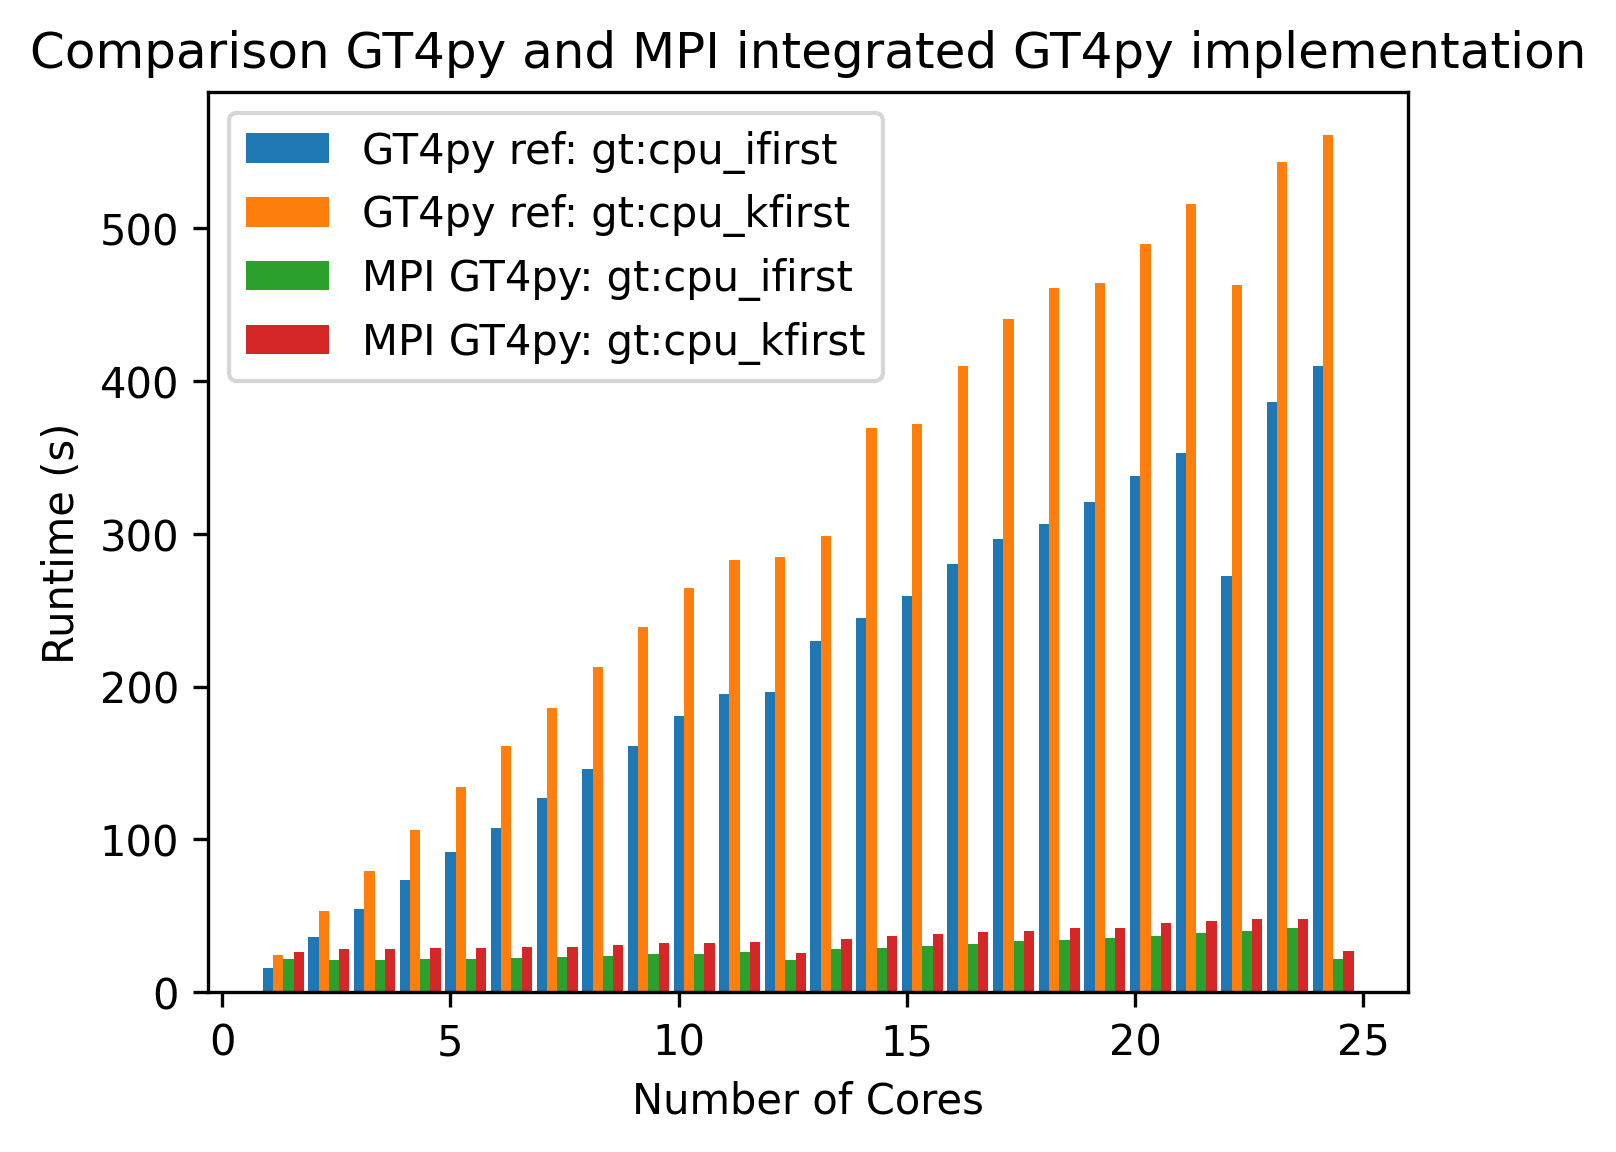

In [6]:

backends = ["gt:cpu_ifirst", "gt:cpu_kfirst"]
version = ["GT4py_ref", 'base']
label= ['GT4py ref', 'MPI GT4py']
name = 'plots/gt4py_ref.png'
title = 'Comparison GT4py and MPI integrated GT4py implementation'
create_figure_absolute(backends, version, title, name, label)

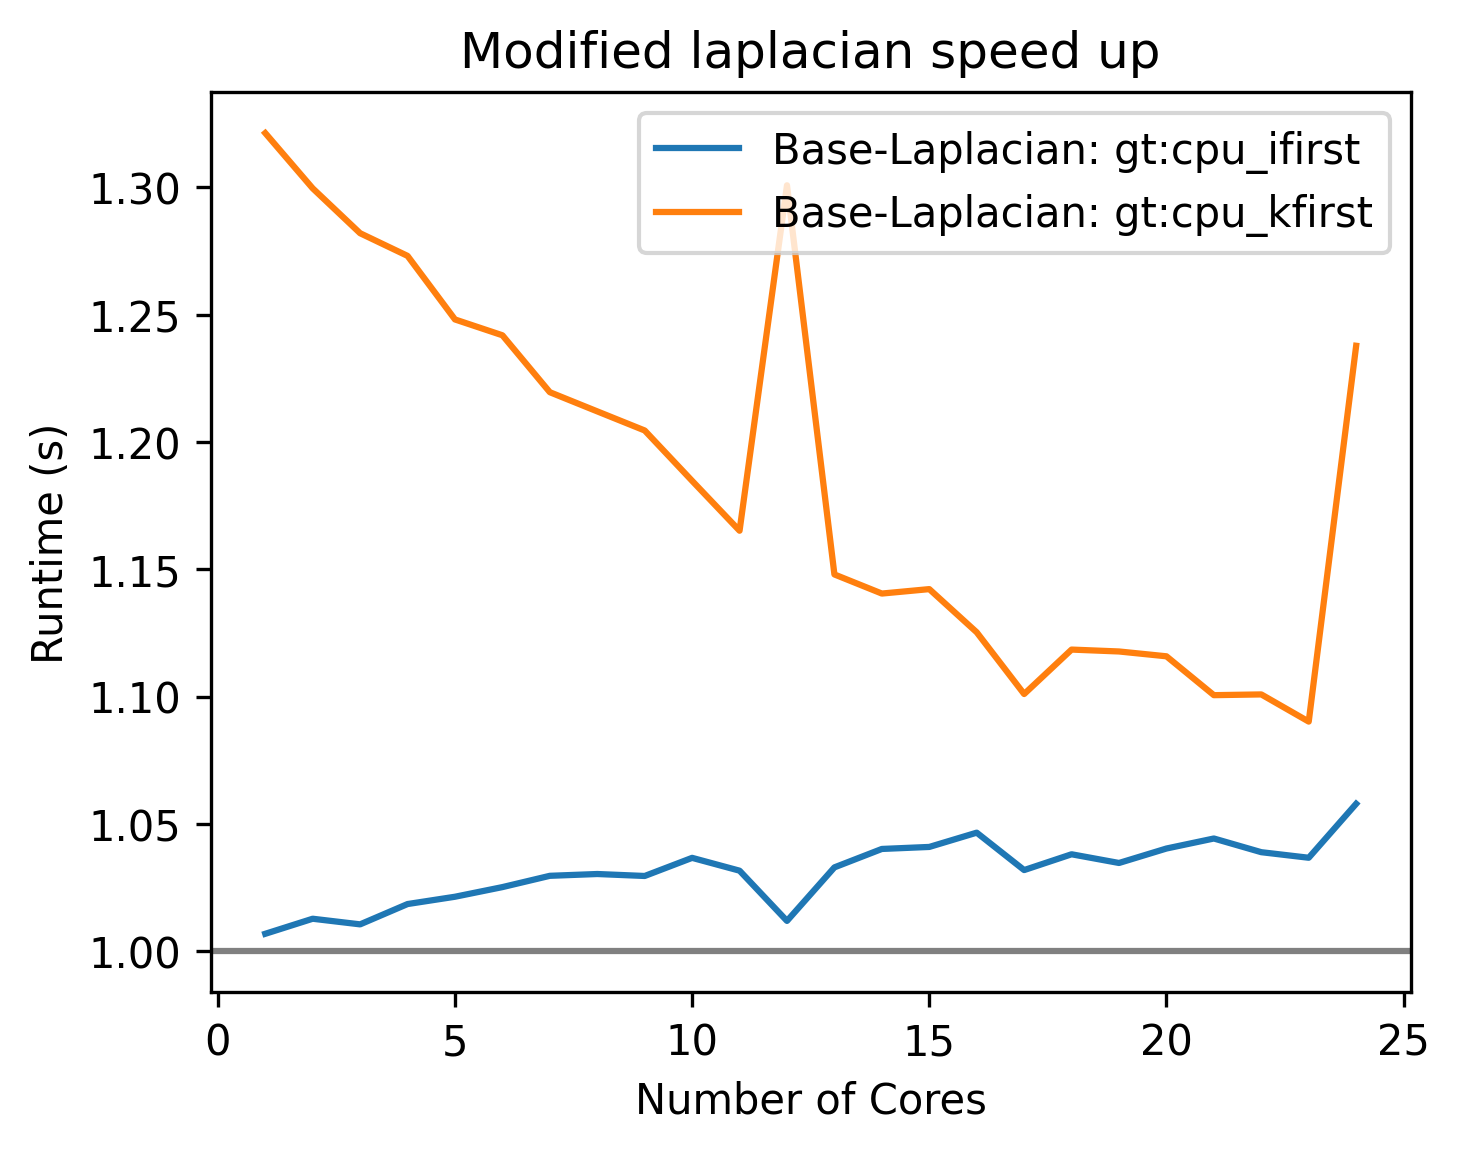

In [50]:
backends = ["gt:cpu_ifirst", "gt:cpu_kfirst"]
version = ["base", 'laplacian']
label= ['Base-Laplacian: gt:cpu_ifirst', 'Base-Laplacian: gt:cpu_kfirst']
comparisons = [[["base", 'laplacian'],["gt:cpu_ifirst","gt:cpu_ifirst"]],[["base", 'laplacian'],["gt:cpu_kfirst","gt:cpu_kfirst"]]]
name = 'plots/gt4py_laplacian_speedup.png'
title = 'Modified laplacian speed up'
create_figure_diff(comparisons, title, name, label)